In [ ]:
import os
import torch
import numpy
import pandas as pd
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
data_dir = r"E:\ProjectsAI\Signature-Recognition\data\signatures"

In [3]:
class_name = os.listdir(data_dir)
class_name

['full_forg', 'full_org', 'Readme.txt']

In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms as T,datasets

In [5]:
device = torch.device("cpu")
device

device(type='cpu')

In [6]:
# transforming the data

data_transform = T.Compose([
    T.Resize(size=(224,224)), #Resizing the image by 224 by 224
    T.RandomRotation(degrees=(-20,+20)), # random rotation of an image
    T.ToTensor(), # converting the dimension (height,weight,channel to channel,height,weight)
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) #Normalise by 3means 3std's of image net
])

In [7]:
data = datasets.ImageFolder(data_dir,transform = data_transform)
total_count = (len(data))

In [8]:
data.classes
total_count

2640

In [9]:
# Splitting the data
train_count = int(0.6 * total_count) # 60% for trainign data 
valid_count = int(0.3 * total_count) # 30% for validation

test_count = total_count - train_count-valid_count

train_data , val_data , test_data = torch.utils.data.random_split(data,(train_count,valid_count,test_count))
print(len(val_data))

792


In [10]:
train_data.dataset

Dataset ImageFolder
    Number of datapoints: 2640
    Root location: E:\ProjectsAI\Signature-Recognition\data\signatures
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [26]:
import numpy as np
import matplotlib.pyplot as plt
def show_image(image,label,get_denormalize=True):
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485,0.456,0.406])
    std = torch.FloatTensor([0.229,0.224,0.225])

    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
    else:
        plt.imshow(image)
        plt.title(label)


In [25]:
def show_grid(image,title=None):
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485,0.456,0.406])
    std = torch.FloatTensor([0.229,0.224,0.225])

    image = image * std + mean
    image = np.clip(image,0,1)

    plt.figure(figsize=[15,15])
    plt.imshow(image)

    if title != None:
        plt.title(title)

In [13]:
def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim=1)
    top_p,top_class = y.pred.topk(1,dim=1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

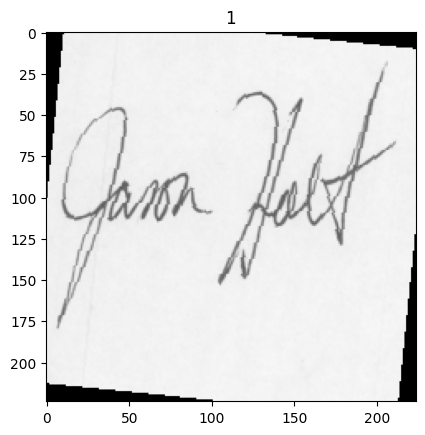

In [34]:
image,label=train_data[0]
show_image(image,label)

In [32]:
# Data loaders

trainloader = DataLoader(train_data,batch_size = 32,shuffle=True)
print("No. of batches in trainloader :{}".format(len(trainloader)))
print("No. of Total examples:{}".format(len(trainloader.dataset)))

validationloader = DataLoader(val_data,batch_size=32,shuffle=True)
print("No. of batches in validationLoader :{}.".format(len(validationloader)))
print("No. of total examples :{}".format(len(validationloader.dataset)))

testloader = DataLoader(test_data,batch_size=32,shuffle=False)
print("No. of batches in testloader :{}".format(len(testloader)))
print("No. of total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader :50
No. of Total examples:1584
No. of batches in validationLoader :25.
No. of total examples :792
No. of batches in testloader :9
No. of total examples:264


In [36]:
# Model - resnet34 model (transfer leanrning model)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms

In [37]:
model=models.resnet34(pretrained=True)

E:\ProjectsAI\Signature-Recognition\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\ProjectsAI\Signature-Recognition\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\systems/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [01:39<00:00, 874kB/s]


In [39]:
model.fc = nn.Sequential (
    nn.Dropout(0.1),
    nn.Linear(model.fc.in_features,len(class_name)))

In [40]:
model = model.to(device)

In [41]:
criterion = torch.nn.CrossEntropyLoss()

In [42]:
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3,momentum=0.9)

In [54]:
def train(model,criterion,optimizer,train_dataloader,test_dataloader):
    total_train_loss=0
    total_test_loss = 0
    model.train()

    with tqdm(train_dataloader,unit='batch',leave=False) as  pbar:
        pbar.set_description(f'training')

        for images,idxs in pbar:
            images = images.to(device,non_blocking=True)
            idxs = idxs.to(device,non_blocking=True)
            output = model(images)


            loss = criterion(output,idxs)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

    model.eval()
    with tqdm(test_dataloader,unit = 'batch',leave=False) as pbar:
        pbar.set_description(f'testing')
        for images,idxs in pbar:
            images = images.to(device,non_blocking=True)
            idxs = idxs.to(device,non_blocking=True)

            output = model(images)
            loss = criterion(output,idxs)
            total_test_loss += loss.item()

    train_acc = total_train_loss/len(train_data)
    test_acc = total_test_loss/len(val_data)
    print(f'Train loss :{train_acc:.4f} test loss : {test_acc}')

In [55]:
%%time
epochs = 2
for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")
    train(model,criterion,optimizer,trainloader,validationloader)

Epoch 1/2


Train loss :0.0003 test loss : 0.00027853005384612415
Epoch 2/2


Train loss :0.0009 test loss : 0.0003378043866086036
CPU times: total: 58min 54s
Wall time: 15min 38s


In [56]:
pwd

'E:\\ProjectsAI\\Signature-Recognition'

In [57]:
path = r'E:\\ProjectsAI\\Signature-Recognition\\model.pt'


In [58]:
torch.save(model,path)

In [62]:
saved_model = torch.load(path,weights_only=False)
saved_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Model Evaluation

In [63]:
def evaluate(model,criterion,optimizer,test_dataloader):

    total_test_loss = 0
    model.eval()
    with tqdm(test_dataloader,unit='batch',leave=False) as pbar:
        pbar.set_description(f'testing')
        for images,idxs in pbar:
            images = images.to(device,non_blocking=True)
            idxs = idxs.to(device,non_blocking=True)

            output = model(images)
            loss = criterion(output,idxs)
            total_test_loss+=loss.item()

        test_acc = total_test_loss/len(val_data)
        print(f'Test loss : {test_acc:.4f}')

In [64]:
evaluate(model,criterion,optimizer,testloader)

Test loss : 0.0001


In [65]:
# Predicition 
label_names = data.classes
label_names

['full_forg', 'full_org']

In [66]:
from PIL import Image

In [71]:
image = Image.open(r'E:\ProjectsAI\Signature-Recognition\data\signatures\full_forg\forgeries_1_2.png')
preprocess = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.Grayscale(3),
    transforms.ToTensor()])

image = preprocess(image)
image = image[:3]

image = image.unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(image)
    probs = torch.softmax(logits,dim=1)
    pred_label = torch.argmax(probs,dim=1)

print(f'Predicted Label : {pred_label.item()}')

predicted_class_name = label_names[pred_label.item()]

print(f'Predicted class name :{predicted_class_name}')

Predicted Label : 1
Predicted class name :full_org
